In [1]:
import pandas as pd
import numpy as np
import holidays
from matplotlib import pyplot as plt
from sklearn import model_selection, preprocessing

ModuleNotFoundError: No module named 'holidays'

#### Introduction

##### Approach

First of all, I noticed that the time series data is irregular and has missing data. So, I resampled and imputed the data. I tried different machine learning models from Sklearn but that didn't work well. After that I switched to deep learning models where I tried neural network and LSTMs with different sequence length but that was also not giving very good results.

After this I decided not to impute data, since it adds bias that the missing data is linearly interpolated. After deep learning models didn't work, I switched to XGBoost, LightGBM and Catboost which gave me an RMSE around ~ 34.

Now, in order to further improve it, I looked into different methods for irregular timeseries like:
1. https://www.youtube.com/watch?v=E4NMZyfao2c
2. Research papers
3. A very nice blog post: https://www.notion.so/Corrupt-sparse-irregular-and-ugly-Deep-learning-on-time-series-887b823df439417bb8428a3474d939b3

But most of these were too complex to try in the short time span. During exploration, I also got the idea of adding holidays to data.

I added more time based features based on https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html and retuned my models. These periodic features help model the periodicity of time.

For neural networks, I modified layers, different hyperparameters and for catboost and lightgbm, I had used hyperopt to search for hyperparams. After that, I finally got the best result as 33.02. 

I am really interested in knowing about 32.02 solution and trying some of the methods mentioned in the blog. My neural networks were trained in different conda environment so those cells have not been run in this notebook.



#### Read Dataset

In [2]:
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')
sample_df = pd.read_csv('dataset/sample.csv')
combined_df = pd.concat([train_df, test_df])

#### Add Time Difference

In [3]:
combined_df.date = pd.to_datetime(combined_df.date)
combined_df.hour = pd.to_timedelta(combined_df.hour, unit='h')
combined_df.index = combined_df.date
combined_df.index = combined_df.index + combined_df.hour
combined_df.drop(['date','hour'], axis=1, inplace=True)
combined_df['prev_time_difference'] = combined_df.index.to_series().diff()/ np.timedelta64(1, 'h')
combined_df = combined_df.dropna(subset=['prev_time_difference'])
combined_df.head()

,demand,prev_time_difference
2018-08-18 10:00:00,21.0,1.0
2018-08-18 13:00:00,23.0,3.0
2018-08-18 14:00:00,104.0,1.0
2018-08-18 15:00:00,81.0,1.0
2018-08-18 16:00:00,37.0,1.0


#### Add Holidays

In [4]:
combined_df['is_holiday'] = 0
karnataka_holidays = holidays.IN(subdiv='KA', years=[2018,2019,2020,2021,2022])

for index, row in combined_df.iterrows():
    if index in karnataka_holidays:
        combined_df.loc[index, 'is_holiday'] = 1

#### Add Time Features

In [5]:
combined_df["day"] = combined_df.index.day
combined_df["week"] = combined_df.index.isocalendar().week
combined_df["month"] = combined_df.index.month
combined_df["quarter"] = combined_df.index.quarter
combined_df["year"] = combined_df.index.year
combined_df["hour"] = combined_df.index.hour
combined_df["dayofyear"] = combined_df.index.dayofyear
combined_df['day_of_week'] = combined_df.index.day_of_week.astype(int)
combined_df["is_month_start"] = combined_df.index.is_month_start.astype(int)
combined_df["is_month_end"] = combined_df.index.is_month_end.astype(int)
combined_df["is_quarter_start"] = combined_df.index.is_quarter_start.astype(int)
combined_df["is_quarter_end"] = combined_df.index.is_quarter_end.astype(int)
combined_df["is_year_start"] = combined_df.index.is_year_start.astype(int)
combined_df["is_year_end"] = combined_df.index.is_year_end.astype(int)
combined_df["is_leap_year"] = combined_df.index.is_leap_year.astype(int)
combined_df["days_in_month"] = combined_df.index.days_in_month
combined_df['is_weekend'] = np.where(combined_df['day_of_week'].isin([5,6]),1,0)

In [6]:
combined_df.head()

,demand,prev_time_difference,is_holiday,day,week,month,quarter,year,hour,dayofyear,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_leap_year,days_in_month,is_weekend
2018-08-18 10:00:00,21.0,1.0,0,18,33,8,3,2018,10,230,5,0,0,0,0,0,0,0,31,1
2018-08-18 13:00:00,23.0,3.0,0,18,33,8,3,2018,13,230,5,0,0,0,0,0,0,0,31,1
2018-08-18 14:00:00,104.0,1.0,0,18,33,8,3,2018,14,230,5,0,0,0,0,0,0,0,31,1
2018-08-18 15:00:00,81.0,1.0,0,18,33,8,3,2018,15,230,5,0,0,0,0,0,0,0,31,1
2018-08-18 16:00:00,37.0,1.0,0,18,33,8,3,2018,16,230,5,0,0,0,0,0,0,0,31,1


#### Adding More Time Related Periodic Features

In [7]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import SplineTransformer
from sklearn.preprocessing import PolynomialFeatures

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

In [8]:
combined_df["sin_week"] = sin_transformer(7).fit_transform(combined_df['week'])
combined_df["sin_month"] = sin_transformer(12).fit_transform(combined_df['month'])
combined_df["sin_quarter"] = sin_transformer(4).fit_transform(combined_df['quarter'])
combined_df["sin_hour"] = sin_transformer(24).fit_transform(combined_df['hour'])
combined_df["sin_dayofyear"] = sin_transformer(365).fit_transform(combined_df['dayofyear'])
combined_df['sin_day_of_week'] = sin_transformer(7).fit_transform(combined_df['day_of_week'])

combined_df["cos_week"] = cos_transformer(7).fit_transform(combined_df['week'])
combined_df["cos_month"] = cos_transformer(12).fit_transform(combined_df['month'])
combined_df["cos_quarter"] = cos_transformer(4).fit_transform(combined_df['quarter'])
combined_df["cos_hour"] = cos_transformer(24).fit_transform(combined_df['hour'])
combined_df["cos_dayofyear"] = cos_transformer(365).fit_transform(combined_df['dayofyear'])
combined_df['cos_day_of_week'] = cos_transformer(7).fit_transform(combined_df['day_of_week'])
combined_df.head()


,demand,prev_time_difference,is_holiday,day,week,month,quarter,year,hour,dayofyear,...,sin_quarter,sin_hour,sin_dayofyear,sin_day_of_week,cos_week,cos_month,cos_quarter,cos_hour,cos_dayofyear,cos_day_of_week
2018-08-18 10:00:00,21.0,1.0,0,18,33,8,3,2018,10,230,...,-1.0,0.500000,-0.729558,-0.974928,-0.222521,-0.5,-1.836970e-16,-0.866025,-0.683919,-0.222521
2018-08-18 13:00:00,23.0,3.0,0,18,33,8,3,2018,13,230,...,-1.0,-0.258819,-0.729558,-0.974928,-0.222521,-0.5,-1.836970e-16,-0.965926,-0.683919,-0.222521
2018-08-18 14:00:00,104.0,1.0,0,18,33,8,3,2018,14,230,...,-1.0,-0.500000,-0.729558,-0.974928,-0.222521,-0.5,-1.836970e-16,-0.866025,-0.683919,-0.222521
2018-08-18 15:00:00,81.0,1.0,0,18,33,8,3,2018,15,230,...,-1.0,-0.707107,-0.729558,-0.974928,-0.222521,-0.5,-1.836970e-16,-0.707107,-0.683919,-0.222521
2018-08-18 16:00:00,37.0,1.0,0,18,33,8,3,2018,16,230,...,-1.0,-0.866025,-0.729558,-0.974928,-0.222521,-0.5,-1.836970e-16,-0.500000,-0.683919,-0.222521


In [9]:
spline_week= periodic_spline_transformer(7, n_splines=3).fit_transform(combined_df['week'].to_numpy().reshape(-1,1))
spline_month= periodic_spline_transformer(12, n_splines=6).fit_transform(combined_df['month'].to_numpy().reshape(-1,1))
spline_quarter= periodic_spline_transformer(4, n_splines=2, degree=2).fit_transform(combined_df['quarter'].to_numpy().reshape(-1,1))
spline_hour= periodic_spline_transformer(24, n_splines=12).fit_transform(combined_df['hour'].to_numpy().reshape(-1,1))
spline_dayofyear= periodic_spline_transformer(365, n_splines=182).fit_transform(combined_df['dayofyear'].to_numpy().reshape(-1,1))
spline_day_of_week= periodic_spline_transformer(7, n_splines=3).fit_transform(combined_df['day_of_week'].to_numpy().reshape(-1,1))

for i in  range(spline_week.shape[1]):
    combined_df[f"spline_week_{i}"] = spline_week[:,i]

for i in  range(spline_month.shape[1]):
    combined_df[f"spline_month_{i}"] = spline_month[:,i]

for i in  range(spline_quarter.shape[1]):
    combined_df[f"spline_quarter_{i}"] = spline_quarter[:,i]

for i in  range(spline_hour.shape[1]):
    combined_df[f"spline_hour_{i}"] = spline_hour[:,i]

for i in  range(spline_dayofyear.shape[1]):
    combined_df[f"spline_dayofyear_{i}"] = spline_dayofyear[:,i]

for i in  range(spline_day_of_week.shape[1]):
    combined_df[f"spline_day_of_week_{i}"] = spline_day_of_week[:,i]

C:\Users\rohan\.conda\envs\analyticsvidhya\lib\site-packages\ipykernel_launcher.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\rohan\.conda\envs\analyticsvidhya\lib\site-packages\ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [10]:
combined_df.head()

,demand,prev_time_difference,is_holiday,day,week,month,quarter,year,hour,dayofyear,...,spline_dayofyear_175,spline_dayofyear_176,spline_dayofyear_177,spline_dayofyear_178,spline_dayofyear_179,spline_dayofyear_180,spline_dayofyear_181,spline_day_of_week_0,spline_day_of_week_1,spline_day_of_week_2
2018-08-18 10:00:00,21.0,1.0,0,18,33,8,3,2018,10,230,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.647716,0.246842,0.105442
2018-08-18 13:00:00,23.0,3.0,0,18,33,8,3,2018,13,230,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.647716,0.246842,0.105442
2018-08-18 14:00:00,104.0,1.0,0,18,33,8,3,2018,14,230,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.647716,0.246842,0.105442
2018-08-18 15:00:00,81.0,1.0,0,18,33,8,3,2018,15,230,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.647716,0.246842,0.105442
2018-08-18 16:00:00,37.0,1.0,0,18,33,8,3,2018,16,230,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.647716,0.246842,0.105442


#### Train Test Split

In [77]:
'''train_data = combined_df[~combined_df.demand.isna()]
test_data = combined_df[combined_df.demand.isna()]

features = combined_df.columns.tolist()
features.remove('demand')
target = ['demand']

X = train_data[features]
y = train_data[target]

#max_demand = y.max().values[0]
#y = y / max_demand

print(X.shape, y.shape)'''

"train_data = combined_df[~combined_df.demand.isna()]\ntest_data = combined_df[combined_df.demand.isna()]\n\nfeatures = combined_df.columns.tolist()\nfeatures.remove('demand')\ntarget = ['demand']\n\nX = train_data[features]\ny = train_data[target]\n\n#max_demand = y.max().values[0]\n#y = y / max_demand\n\nprint(X.shape, y.shape)"

In [76]:
features = combined_df.columns.tolist()
features.remove('demand')
target = ['demand']

train_data = combined_df.loc[:'2020-08-01']
X_train = train_data[features].values
y_train = train_data[target].values

val_data = combined_df.loc['2020-08-01':'2020-12-27']
X_val = val_data[features].values
y_val = val_data[target].values

test_data = combined_df[combined_df.demand.isna()]
X_test = test_data[features].values

<AxesSubplot:>

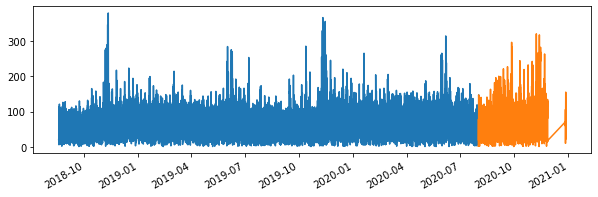

In [78]:
fig, axs = plt.subplots(1,1, figsize=(10,3))
train_data.demand.plot()
val_data.demand.plot()


#### Model

In [69]:
from catboost import CatBoostRegressor, metrics, Pool, cv
from sklearn.preprocessing import StandardScaler

In [71]:
params = {
    'n_estimators':50000,
    'learning_rate': 0.0005,
    #'random_seed': 11,
    'eval_metric':"MSLE",
    'max_depth': 8,
    'use_best_model':True,
    'early_stopping_rounds':500,
}

train_pool = Pool(X_train, y_train)
validate_pool = Pool(X_val, y_val)

model = CatBoostRegressor(**params).fit(train_pool, eval_set=validate_pool,  verbose=10)
feature_importances = model.get_feature_importance(train_pool)
feature_names = features
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

0:	learn: 0.4955353	test: 0.5359517	best: 0.5359517 (0)	total: 8.95ms	remaining: 7m 27s
10:	learn: 0.4948473	test: 0.5349230	best: 0.5349230 (10)	total: 98.1ms	remaining: 7m 25s
20:	learn: 0.4941625	test: 0.5339216	best: 0.5339216 (20)	total: 189ms	remaining: 7m 29s
30:	learn: 0.4934721	test: 0.5329177	best: 0.5329177 (30)	total: 282ms	remaining: 7m 35s
40:	learn: 0.4927992	test: 0.5319499	best: 0.5319499 (40)	total: 382ms	remaining: 7m 45s
50:	learn: 0.4921361	test: 0.5309573	best: 0.5309573 (50)	total: 475ms	remaining: 7m 44s
60:	learn: 0.4914755	test: 0.5300131	best: 0.5300131 (60)	total: 581ms	remaining: 7m 55s
70:	learn: 0.4908268	test: 0.5290907	best: 0.5290907 (70)	total: 683ms	remaining: 8m
80:	learn: 0.4901717	test: 0.5281333	best: 0.5281333 (80)	total: 782ms	remaining: 8m 1s
90:	learn: 0.4895318	test: 0.5272266	best: 0.5272266 (90)	total: 883ms	remaining: 8m 4s
100:	learn: 0.4889078	test: 0.5263478	best: 0.5263478 (100)	total: 987ms	remaining: 8m 7s
110:	learn: 0.4882810	test

In [74]:
X_test = test_data[features].values
y_test = model.predict(X_test)

In [75]:
sample_df.demand = y_test
sample_df.to_csv('submission_new_catboost.csv', index=False)

#### ML Models using Sklearn

In [47]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor ,AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, ElasticNet, LassoLars, PassiveAggressiveRegressor
from sklearn.svm import SVR, NuSVR
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [53]:
regs = [RandomForestRegressor(), AdaBoostRegressor(), GradientBoostingRegressor(), LinearRegression(), Ridge(), Lasso(), BayesianRidge(), ElasticNet(), LassoLars(), PassiveAggressiveRegressor(), SVR(), KNeighborsRegressor(), DecisionTreeRegressor()] 
for reg in regs:
        reg.fit(X_train, y_train.ravel())
        y_pred = reg.predict(X_val)
        print("{} : {}".format( reg.__class__, mean_squared_error(y_val.ravel(), y_pred.ravel(), squared=False)))

<class 'sklearn.ensemble._forest.RandomForestRegressor'> : 38.96363750353461
<class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'> : 38.35987181283176
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'> : 37.55387633209891
<class 'sklearn.linear_model._base.LinearRegression'> : 43.682369422012094
<class 'sklearn.linear_model._ridge.Ridge'> : 43.097428392362495
<class 'sklearn.linear_model._coordinate_descent.Lasso'> : 40.32254211865332
<class 'sklearn.linear_model._bayes.BayesianRidge'> : 42.33874129240357
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'> : 44.09116749608297


C:\Users\rohan\.conda\envs\analyticsvidhya\lib\site-packages\sklearn\linear_model\_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


<class 'sklearn.linear_model._least_angle.LassoLars'> : 45.53203992420021
<class 'sklearn.linear_model._passive_aggressive.PassiveAggressiveRegressor'> : 48.02066801571669
<class 'sklearn.svm._classes.SVR'> : 45.95836101241908
<class 'sklearn.neighbors._regression.KNeighborsRegressor'> : 41.516219771428965
<class 'sklearn.tree._classes.DecisionTreeRegressor'> : 48.772654026840875


In [79]:
regs = [
('rf',RandomForestRegressor()),
('gb',GradientBoostingRegressor()),
('ab',AdaBoostRegressor()),
]

In [80]:
reg = VotingRegressor(regs)
reg.fit(X_train, y_train.ravel())
y_pred = reg.predict(X_val)
mean_squared_error(y_val.ravel(), y_pred.ravel(), squared=False)

37.8819653326573

#### Light GBM

In [81]:
from lightgbm import LGBMRegressor

In [82]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from tqdm.notebook import tqdm


def hyperopt_objective(args):
    n_jobs = 2
    default_params = {"seed": 42}
    params = {
        "boosting": args["boosting"],
        "learning_rate": args["learning_rate"],
        "num_iterations": int(args["num_iterations"]),
        "num_leaves": int(args["num_leaves"]),
        "max_depth": int(args["max_depth"]),
        "min_data_in_leaf": int(args["min_data_in_leaf"]),
        "min_sum_hessian_in_leaf": args["min_sum_hessian_in_leaf"],
        "bagging_fraction": args["bagging_fraction"],
        "bagging_freq": int(args["bagging_freq"]),
        "feature_fraction": args["feature_fraction"],
        "extra_trees": args["extra_trees"],
        "lambda_l1": args["lambda_l1"],
        "lambda_l2": args["lambda_l2"],
        "path_smooth": args["path_smooth"],
        "max_bin": int(args["max_bin"]),
    }
    default_params.update(params)
    model = LGBMRegressor(**default_params)

    eval_set = [(X_val, y_val)]
    model.fit(X_train, y_train, eval_set=eval_set,
              early_stopping_rounds=10, verbose=False, eval_metric='rmse')
    best_rmse = min(model.evals_result_['valid_0']['rmse'])
    return best_rmse

In [84]:
'''space = {
    "boosting": hp.pchoice("boosting", [(0.75, "gbdt"), (0.25, "dart")]),
    "learning_rate": 10 ** hp.uniform("learning_rate", -2, 0),
    "num_iterations": hp.quniform("num_iterations", 1, 1000, 1),
    "num_leaves": 2 ** hp.uniform("num_leaves", 1, 8),
    "max_depth": -1,
    "min_data_in_leaf": 2 * 10 ** hp.uniform("min_data_in_leaf", 0, 2),
    "min_sum_hessian_in_leaf": hp.uniform("min_sum_hessian_in_leaf", 1e-4, 1e-2),
    "bagging_fraction": hp.uniform("bagging_fraction", 0.5, 1.0),
    "bagging_freq": hp.qlognormal("bagging_freq", 0.0, 1.0, 1),
    "feature_fraction": hp.uniform("feature_fraction", 0.5, 1.0),
    "extra_trees": hp.pchoice("extra_trees", [(0.75, False), (0.25, True)]),
    "lambda_l1": hp.lognormal("lambda_l1", 0.0, 1.0),
    "lambda_l2": hp.lognormal("lambda_l2", 0.0, 1.0),
    "path_smooth": hp.lognormal("path_smooth", 0.0, 1.0),
    "max_bin": 2 ** hp.quniform("max_bin", 6, 10, 1) - 1,
}

trials = Trials()

best = fmin(fn=hyperopt_objective,
            space=space,
            algo=tpe.suggest,
            max_evals=500,
            trials=trials)'''

'space = {\n    "boosting": hp.pchoice("boosting", [(0.75, "gbdt"), (0.25, "dart")]),\n    "learning_rate": 10 ** hp.uniform("learning_rate", -2, 0),\n    "num_iterations": hp.quniform("num_iterations", 1, 1000, 1),\n    "num_leaves": 2 ** hp.uniform("num_leaves", 1, 8),\n    "max_depth": -1,\n    "min_data_in_leaf": 2 * 10 ** hp.uniform("min_data_in_leaf", 0, 2),\n    "min_sum_hessian_in_leaf": hp.uniform("min_sum_hessian_in_leaf", 1e-4, 1e-2),\n    "bagging_fraction": hp.uniform("bagging_fraction", 0.5, 1.0),\n    "bagging_freq": hp.qlognormal("bagging_freq", 0.0, 1.0, 1),\n    "feature_fraction": hp.uniform("feature_fraction", 0.5, 1.0),\n    "extra_trees": hp.pchoice("extra_trees", [(0.75, False), (0.25, True)]),\n    "lambda_l1": hp.lognormal("lambda_l1", 0.0, 1.0),\n    "lambda_l2": hp.lognormal("lambda_l2", 0.0, 1.0),\n    "path_smooth": hp.lognormal("path_smooth", 0.0, 1.0),\n    "max_bin": 2 ** hp.quniform("max_bin", 6, 10, 1) - 1,\n}\n\ntrials = Trials()\n\nbest = fmin(fn=hyp

In [95]:
n_jobs = 2
params = {
    'n_estimators':50000,
    'learning_rate': 0.0005,
    #'seed': 11,
    'eval_metric':"MSLE",
    'max_depth': 6,
    'use_best_model':True,
    'early_stopping_rounds':500,
}

model = LGBMRegressor(**params)
eval_set = [(X_val, y_val)]
model.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=10, verbose=True, eval_metric='rmse')

C:\Users\rohan\.conda\envs\analyticsvidhya\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\rohan\.conda\envs\analyticsvidhya\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\rohan\.conda\envs\analyticsvidhya\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future 

[1]	valid_0's rmse: 47.9929	valid_0's l2: 2303.32
[2]	valid_0's rmse: 47.9847	valid_0's l2: 2302.53
[3]	valid_0's rmse: 47.9764	valid_0's l2: 2301.73
[4]	valid_0's rmse: 47.9681	valid_0's l2: 2300.94
[5]	valid_0's rmse: 47.9599	valid_0's l2: 2300.15
[6]	valid_0's rmse: 47.9516	valid_0's l2: 2299.36
[7]	valid_0's rmse: 47.9434	valid_0's l2: 2298.57
[8]	valid_0's rmse: 47.9352	valid_0's l2: 2297.78
[9]	valid_0's rmse: 47.927	valid_0's l2: 2297
[10]	valid_0's rmse: 47.9188	valid_0's l2: 2296.21
[11]	valid_0's rmse: 47.9106	valid_0's l2: 2295.42
[12]	valid_0's rmse: 47.9024	valid_0's l2: 2294.64
[13]	valid_0's rmse: 47.8942	valid_0's l2: 2293.86
[14]	valid_0's rmse: 47.886	valid_0's l2: 2293.07
[15]	valid_0's rmse: 47.8779	valid_0's l2: 2292.29
[16]	valid_0's rmse: 47.8697	valid_0's l2: 2291.51
[17]	valid_0's rmse: 47.8616	valid_0's l2: 2290.73
[18]	valid_0's rmse: 47.8535	valid_0's l2: 2289.95
[19]	valid_0's rmse: 47.8453	valid_0's l2: 2289.17
[20]	valid_0's rmse: 47.8372	valid_0's l2: 22

LGBMRegressor(early_stopping_rounds=500, eval_metric='MSLE',
              learning_rate=0.0005, max_depth=6, n_estimators=50000,
              use_best_model=True)

In [96]:
y_test = model.predict(X_test)
sample_df.demand = y_test
sample_df.to_csv('submission_lgbm.csv', index=False)

#### Neural Network

In [ ]:
import torch
import os.path as osp
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

In [ ]:
train_scaler = StandardScaler().fit(X_train)
target_scaler = StandardScaler().fit(y_train)

X_train = train_scaler.transform(X_train)
y_train = target_scaler.transform(y_train)

X_val = train_scaler.transform(X_val)
y_val = target_scaler.transform(y_val)

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.__len__()

    def __getitem__(self, idx):
        return np.array(self.X[idx], dtype=float), np.array(self.y[idx], dtype='float')

In [ ]:
class TimeSeriesModel(nn.Module):
    def __init__(self, num_features):
        super(TimeSeriesModel, self).__init__()
        self.linear1 = nn.Linear(num_features, 128)
        self.linear2 = nn.Linear(128,64)
        self.linear3 = nn.Linear(64,16)
        self.linear4 = nn.Linear(16,1)

        self.dropout = nn.Dropout(0.5)
        self.activation1 = nn.ReLU()
        
    def forward(self, x):
        x = self.dropout(self.linear1(x))
        x = self.activation1(x)
        x = self.dropout(self.linear2(x))
        x = self.activation1(x)
        x = self.dropout(self.linear3(x))
        x = self.activation1(x)
        x = self.linear4(x)
        return x

In [ ]:
# Hyperparameters
n_epochs = 1000
n_epochs_stop = 30
input_size = X_train.shape[1]
output_size = 1
batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_dir = 'models'

In [ ]:
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model = TimeSeriesModel(num_features=input_size).cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
best_loss = np.inf
epochs_no_improve = 0
model_name = 'nn_model_new'
for epochs in range(1, n_epochs+1):
    train_loss = 0
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        data = torch.Tensor(np.array(data)).to(device)
        target = target.reshape(-1,1)
        output = model(data.float())
        loss = criterion(output, target.float().to(device))
        if type(criterion) == torch.nn.modules.loss.MSELoss:
            loss = torch.sqrt(loss)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data = torch.Tensor(np.array(data)).to(device)
            target = target.reshape(-1,1)
            output = model(data.float())
            loss = criterion(output, target.float().to(device))
            if type(criterion) == torch.nn.modules.loss.MSELoss:
                loss = torch.sqrt(loss)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    # early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), osp.join(model_dir, '{}.pt'.format(model_name)))
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    if epochs_no_improve == n_epochs_stop:
        #print("Early stopping.")
        break
    print(f'Epoch {epochs} train loss: {round(train_loss,8)} val loss: {round(val_loss,8)}')
print('best loss: {}'.format(best_loss))

In [ ]:
model = TimeSeriesModel(num_features=input_size).cuda()
model.load_state_dict(torch.load('models/{}.pt'.format(model_name)))
model.eval()

In [ ]:
predictions = []
true = []
with torch.no_grad():
    for data, target in val_loader:
        data = torch.Tensor(np.array(data)).to(device)
        output = model(data.float())
        predictions.extend(output.squeeze().tolist())
        true.extend(target.squeeze().tolist())

In [ ]:
from sklearn.metrics import mean_squared_error

true = target_scaler.inverse_transform(np.array(true).reshape(-1,1)).flatten()
predictions = target_scaler.inverse_transform(np.array(predictions).reshape(-1,1)).flatten()
print(mean_squared_error(true, predictions, squared=False))

In [ ]:
X_test = train_scaler.transform(X_test)
test_dataset = TimeSeriesDataset(X_test, y_train)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
predictions = []
true = []
with torch.no_grad():
    for data, target in test_loader:
        data = torch.Tensor(np.array(data)).to(device)
        output = model(data.float())
        predictions.extend(output.squeeze().tolist())
        true.extend(target.squeeze().tolist())

predictions = target_scaler.inverse_transform(np.array(predictions).reshape(-1,1)).flatten()

In [ ]:
sample_df.demand = predictions
sample_df.to_csv('submission_nn.csv', index=False)

#### LSTM

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = X
        self.y = y
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - self.seq_len

    def __getitem__(self, idx):
        return np.array(self.X[idx:idx+self.seq_len]), np.array(self.y[idx+self.seq_len])

In [ ]:
class Model_LSTM(nn.Module):
    def __init__(self, num_features, hidden_units, timesteps, lstm_layers=1):
        
        super().__init__()
        self.num_features = num_features  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = lstm_layers
        self.seq_len = timesteps
        # self.proj_size = 64
        dense1 = 1024
        dense2 = 512
        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers,
            dropout = 0.2,
            # proj_size = self.proj_size
        )
        # self.lstm_linear = nn.Linear(in_features=self.hidden_units*self.num_layers, out_features=1024)
        self.dropout = nn.Dropout(0.3)
        self.lstm_linear = nn.Linear(self.seq_len*self.hidden_units,dense1)
        self.linear_mid = nn.Linear(dense1,dense2)
        self.linear_out = nn.Linear(dense2,1)
    def forward(self, x):
        
        lstm_out, (hn, _) = self.lstm(x)
        
        ## all lstm layer hidden states
        lstm_out = lstm_out.reshape(lstm_out.shape[0], -1)
        out0 = self.lstm_linear(lstm_out)
        out0 = self.dropout(out0)
        
        out1 = self.linear_mid(out0)
        out1 = self.dropout(out1)
        out = self.linear_out(out1)
        return out

In [ ]:
# Hyperparameters
n_epochs = 100
n_epochs_stop = 30
input_size = X_train.shape[1]
output_size = 1
batch_size = 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_dir = 'models'

In [ ]:
sequence_length = 30

train_dataset = TimeSeriesDataset(X_train, y_train, seq_len=sequence_length)
val_dataset = TimeSeriesDataset(X_val, y_val, seq_len=sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model = Model_LSTM(num_features=input_size, hidden_units=128, timesteps=sequence_length, lstm_layers=3).cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
best_loss = np.inf
epochs_no_improve = 0
model_name = 'nn_model_lstm'
for epochs in range(1, n_epochs+1):
    train_loss = 0
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        data = torch.Tensor(np.array(data)).to(device)
        target = target.reshape(-1,1)
        output = model(data.float())
        loss = criterion(output, target.float().to(device))
        if type(criterion) == torch.nn.modules.loss.MSELoss:
            loss = torch.sqrt(loss)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data = torch.Tensor(np.array(data)).to(device)
            target = target.reshape(-1,1)
            output = model(data.float())
            loss = criterion(output, target.float().to(device))
            if type(criterion) == torch.nn.modules.loss.MSELoss:
                loss = torch.sqrt(loss)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    # early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), osp.join(model_dir, '{}.pt'.format(model_name)))
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    if epochs_no_improve == n_epochs_stop:
        #print("Early stopping.")
        break
    print(f'Epoch {epochs} train loss: {round(train_loss,8)} val loss: {round(val_loss,8)}')
print('best loss: {}'.format(best_loss))

In [ ]:
model = Model_LSTM(num_features=input_size, hidden_units=128, timesteps=sequence_length, lstm_layers=3).cuda()
model.load_state_dict(torch.load('models/{}.pt'.format(model_name)))
model.eval()

In [ ]:
predictions = []
true = []
with torch.no_grad():
    for data, target in val_loader:
        data = torch.Tensor(np.array(data)).to(device)
        output = model(data.float())
        predictions.extend(output.squeeze().tolist())
        true.extend(target.squeeze().tolist())

In [ ]:
from sklearn.metrics import mean_squared_error

true = target_scaler.inverse_transform(np.array(true).reshape(-1,1)).flatten()
predictions = target_scaler.inverse_transform(np.array(predictions).reshape(-1,1)).flatten()
print(mean_squared_error(true, predictions, squared=False))

In [ ]:
test_dataset = TimeSeriesDataset(X_test, y_train, seq_len=sequence_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
predictions = []
true = []
with torch.no_grad():
    for data, target in test_loader:
        data = torch.Tensor(np.array(data)).to(device)
        output = model(data.float())
        predictions.extend(output.squeeze().tolist())
        true.extend(target.squeeze().tolist())

predictions = target_scaler.inverse_transform(np.array(predictions).reshape(-1,1)).flatten()

In [ ]:
sample_df.demand = predictions
sample_df.to_csv('submission_lstm.csv', index=False)